# How to use the time-lagged autoencoder

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
import tae

Our test system is a simple two-dimensional two-state process with a one-dimensional dominant slow component.

We start by generating a trajectory along with the underlying hidden state time series and visualize the two-dimensional data:

In [75]:
data = np.load(r"../../data/dimredux-challenge-01-data.npz",  'r') 
for key in (data.keys().__iter__()): 
    print(key)

with np.load(r"../../data/dimredux-challenge-01-data.npz") as fh:
    data_x  = fh["data_x"]
    x_train = fh['validation_x']
    y_train = fh['validation_y']

data_x
validation_x
validation_y


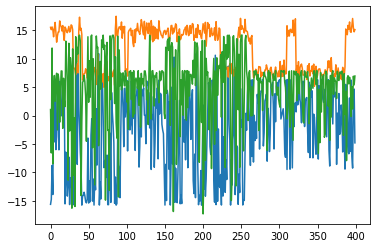

In [76]:
plt.plot(x_train[0:400])

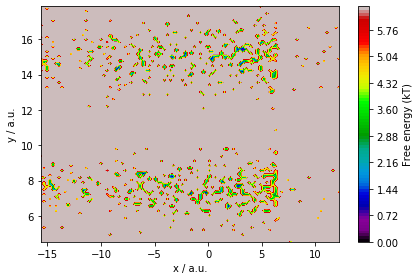

In [77]:
fig, ax = pyemma.plots.plot_free_energy(*x_train.T, cmap=mpl.cm.nipy_spectral)
ax.set_xlabel('x / a.u.')
ax.set_ylabel('y / a.u.')
fig.tight_layout()

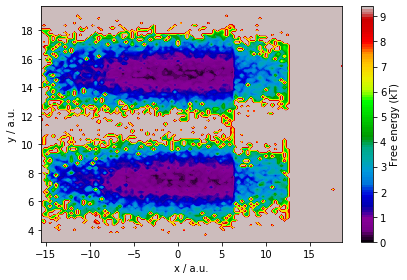

In [78]:
fig, ax = pyemma.plots.plot_free_energy(*data_x.T, cmap=mpl.cm.nipy_spectral)
ax.set_xlabel('x / a.u.')
ax.set_ylabel('y / a.u.')
fig.tight_layout()

We clearly see two metastable shapes which are not connected along a single direction which should make it difficult to find a suitable one-dimensional representation.

In the next step, we apply the autoencoder API function to find such a one-dimensional embedding. This function returns the learned embedding and also the training and validation loss which we will visualize to show the minimization behavior:

/Users/julian/anaconda2/envs/DeepLearningUni/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


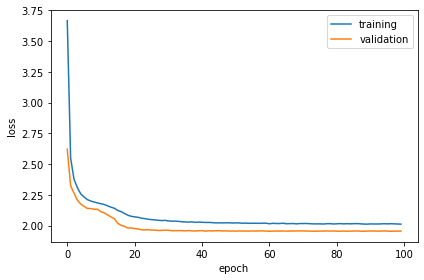

In [79]:
embedding, training_loss, validation_loss = tae.ae(
    data_x, dim=1, lag=1, n_epochs=100, validation_split=0.5, whiten=True, hid_size=[200, 100])

fig, ax = plt.subplots()
ax.plot(training_loss, label='training')
ax.plot(validation_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
fig.tight_layout()

The saturated training and validation losses hint that overfitting is unlikely.

Then, we test the one-dimensional embedding whether it has found the correct slow component by building two Markov state models (MSMs), one on the embedding and one on the hidden state trajectory, and compare their first implied timescales:

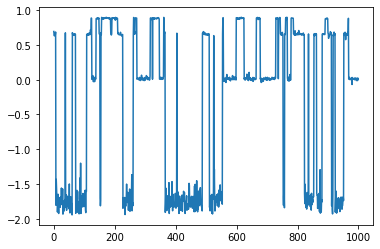

In [80]:
plt.plot(embedding[:1000])

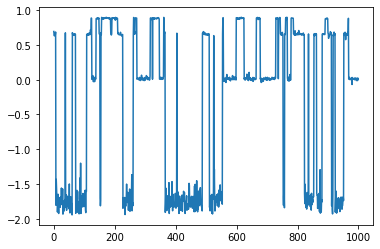

In [91]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(embedding)
prediction = kmeans.predict(embedding)

plt.plot(embedding[0:1000])
plt.show()

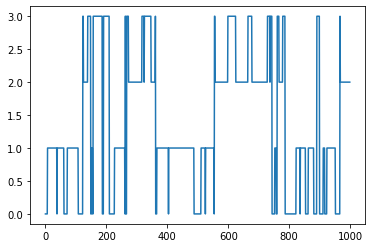

In [90]:
plt.plot(prediction[0:1000])


In [83]:
type(y_kmeans[0])
print(type(y_kmeans[0]) == np.int32)

True


In [85]:
assert prediction.ndim == 1
assert prediction.shape[0] == 100000
assert type(prediction[0])== np.int32
# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction)

# Validate Model 

/Users/julian/anaconda2/envs/DeepLearningUni/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


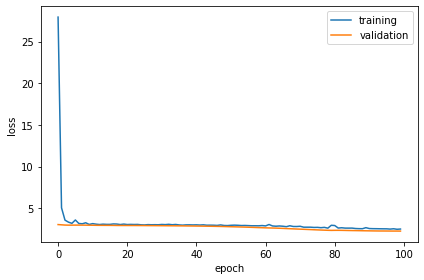

In [51]:
embedding, training_loss, validation_loss = tae.ae(
    x_train, dim=1, lag=1, n_epochs=100, validation_split=0.5, whiten=True, hid_size=[200, 100])

fig, ax = plt.subplots()
ax.plot(training_loss, label='training')
ax.plot(validation_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
fig.tight_layout()

In [62]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(x_train)
y_kmeans = kmeans.predict(x_train)

In [63]:
def return_accuracy(train, test):
    counter = 0
    for i in range(len(train)): 
        if train[i] == test[i]: 
            counter+=1
    accuracy = counter/len(test)
    return accuracy

accuracy = return_accuracy(y_kmeans, y_train)
print(accuracy)

0.378


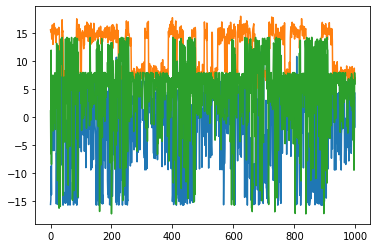

In [64]:

plt.plot(x_train)
plt.show()